/var/folders/5g/_gdkfx8s4nzcbr21_35z4w2w0000gn/T/ipykernel_68097/2455936965.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Code name'] = df['Code name'].fillna("0")


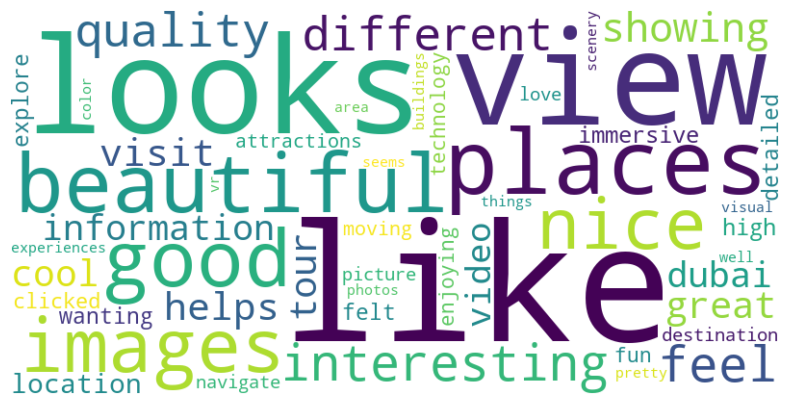

Top 10 Unique Words:
['attractions', 'destination', 'experiences', 'interesting', 'information', 'technology', 'buildings', 'beautiful', 'different', 'immersive']
-----------------------
Comments assigned to 'attractions':
it was very quick and reactive
It was interactive
very helpful to move around like this
I had control over where to go
this is interactive.
I like all the interactions that you can do by clicking just from your screen
NICE AND INTERACTIVE
It gave me actual movies of doing things.
this is a decent selection of areas to explore
The interface makes sense and is good at being low-profile.
A great deal of ease, no problems doing what I wanted
open for anyone
I love the frame rate
Lighting was nice, everything was bright and filled with colors
It was relaxing
Considering I could probably spend a few days, just on this virtual tour, then there's no shortage of things to actually see, when I'm there.
Opulent
attractive
It was well done
The tour was excellent
this is really n

In [13]:
import pandas as pd
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import string
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import csv


def removing_extra_columns(df):  
    selected_columns = ['Order', 'VR quality', 'Code name']
    df = df[selected_columns]
    df['Code name'] = df['Code name'].fillna("0")
    return df

def creating_word_cloud(df):
    df['VR quality'] = df['VR quality'].fillna("")
    comments = ' '.join(df['VR quality'])
    pattern_to_remove = r"\b\w+'\b"  # Corrected pattern to remove words with apostrophes
    all_comments = re.sub(pattern_to_remove, '', comments)
    
    stop_words = set(stopwords.words('english'))
    punctuations = set(string.punctuation)
    stemmer = SnowballStemmer("english")

    # removing extra unnecssary words 
    stop_words.update(['easy', 'see', "way", 'use', 'clear', 'could', 'able', 'city', 'would', 'lot', 'around', 'get', 'go', 'many', 'making', 'many', "really","actually"])

    # Removing stopwords and punctuation from all_comments
    filtered_comments = ' '.join([word.lower() for word in all_comments.split() if word.lower() not in stop_words and word.lower() not in punctuations])

    words = filtered_comments.split()

    stem_to_original = {}

    stemmed_words = []
    for word in words:
        stemmed = stemmer.stem(word.lower())
        if stemmed not in stop_words and stemmed not in punctuations:
            stemmed_words.append(stemmed)
            stem_to_original[stemmed] = word.lower()

    word_counts = Counter(stemmed_words)

    # Getting the top 50 most repeated words 
    top_50_words = {stem_to_original[word]: count for word, count in word_counts.most_common(50)}

    # Generating word cloud for top 50 most repeated words 
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_50_words)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    
    return top_50_words

def calculate_unique_words(top_50_words, threshold=0.1):
    word_vectors = []
    for word in top_50_words:
        vector = [1 if word == w else 0 for w in top_50_words]  # Using 1 if the words are the same, 0 otherwise
        word_vectors.append(vector)

    # Calculating cosine similarity between all pairs of words
    similarity_scores = cosine_similarity(word_vectors)

    # Initialize a set to store unique words
    unique_words = set()

    # Filtering out words that are below the threshold of similarity
    for i, word in enumerate(top_50_words):
        if all(similarity_scores[i][j] < threshold for j in range(len(top_50_words)) if j != i):
            unique_words.add(word)

    # getting top 10 most dissimliar words with longest length in words
    unique_words = sorted(unique_words, key=lambda x: len(x), reverse=True)[:10]

    return unique_words


def generate_comments_dict(all_comments, unique_words):
    # Initialize TF-IDF vectorizer
    vectorizer = TfidfVectorizer(stop_words='english', vocabulary=unique_words)
    tfidf_matrix = vectorizer.fit_transform(all_comments)
    feature_names = vectorizer.get_feature_names_out()

    # Initializing dictionary to store comments assigned to unique words
    comments_assigned_to_unique_words = {word: [] for word in unique_words}

    # Assign each comment to the most similar unique word
    for i in range(len(all_comments)):
        comment = all_comments[i]
        tfidf_vector = tfidf_matrix[i]
        most_similar_word_index = np.argmax(tfidf_vector)
        most_similar_word = feature_names[most_similar_word_index]
        comments_assigned_to_unique_words[most_similar_word].append(comment)

    # Converting dictionary to the desired format
    comments_dict = {}
    for word, comments in comments_assigned_to_unique_words.items():
        comments_dict[word] = comments

    return comments_dict

def main():
    df = pd.read_csv("data/vr_comments.csv")
    df = removing_extra_columns(df)

    top_50_words = creating_word_cloud(df)

    unique_words = calculate_unique_words(top_50_words)
    
    top_10_unique_words = list(unique_words)[:10]
    print("Top 10 Unique Words:")
    print(top_10_unique_words)
    print("-----------------------")

    
    # -------------------Creating CSV File for new labels----------------------------------
    
    # with open('data/unique_words_comments.csv', 'w', newline='') as csvfile:
    #     fieldnames = ['Unique Word', 'Comments']
    #     writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    #     writer.writeheader()
    #     for word, comments in comments_dict.items():
    #         for comment in comments:
    #             writer.writerow({'Unique Word': word, 'Comments': comment})
#-------------------------------------------------------------------------------------------

    comments_dict = generate_comments_dict(df['VR quality'], unique_words)
    for word, comments in comments_dict.items():
        print(f"Comments assigned to '{word}':")
        for comment in comments:
            print(comment)
        print()

if __name__ == "__main__":
    main()


### Making unique dictionaries

In [35]:
import pandas as pd

df = pd.read_csv("data/clean_vr_comments.csv")

comments_dict = {}
for label in df["Code name"].unique():
    comments_for_label = df[df["Code name"] == label]["VR quality"].tolist()
    comments_dict[label] = comments_for_label

print("Choose a label from the following options:")
label_options = df["Code name"].unique()
for index, label in enumerate(label_options, start=1):
    print(f"{index}. {label}")

while True:
    choice = input("Enter the name of the label: ")
    if choice in label_options:
        break
    else:
        print("Invalid label. Please enter a valid label.")

selected_label = choice
if selected_label in comments_dict:
    selected_comments = comments_dict[selected_label]
    print(f"\nTotal comments found for label '{selected_label}': {len(selected_comments)}")
    print(f"\nComments for label '{selected_label}':")
    for comment in selected_comments:
        print(comment)
else:
    print("No comments found for the selected label.")


Choose a label from the following options:
1. Utilitarian-Interaction
2.  High-quality Content preparation
3. Overall user interface satisfaction 
4. Easy to use (overall)
5. Lots to do
6. Utilitarian-Others
7. frame rate
8. Lighting 
9. Relaxing experience
10. 0
11. Luxury experience
12. Attractiveness
13. General perceived quality
14. Cleaness and neatness
15. High quality (overall)
16. Up to date technology
17. Sofisticated design
18. Overall destination preview
19. Engaging experience
20. Excitement
21. Ability to click on destination labels
22. High-quality technology (overall)
23. Discuss latter
24. Comprehensive design
25. Variety of places
26. Informative
27. Overall Useful/helpful information
28. To increase the destiantion knowledge
29. To get location and layout information
30. To plan the travel
31. To know the destination activites
32. Inside-building view
33. Hotel plan
34. Desination architecture
35. Easy to use (Overall)
36. Helful tour guide
37. Efficient to learn
38. 

### Applying Sentimental Analysis 

In [33]:
from textblob import TextBlob
from nltk.corpus import stopwords
import pandas as pd

stop_words = set(stopwords.words('english'))

# Apply sentiment analysis to all comments
df['Sentiment'] = df['VR quality'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Classify sentiments into positive, neutral, and negative based on polarity
df['Sentiment Type'] = pd.cut(df['Sentiment'],
                                bins=[-1, -0.01, 0.01, 1],
                                labels=['Negative', 'Neutral', 'Positive'])

# Overview of sentiment distribution
sentiment_distribution = df['Sentiment Type'].value_counts(normalize=True) * 100

# Filter out stopwords before sentiment analysis
def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word.lower() not in stop_words])

df['VR quality'] = df['VR quality'].apply(remove_stopwords)

negative_neutral_comments = df[df['Sentiment Type'].isin(['Negative', 'Neutral'])]['VR quality']

percentage_negative_neutral = (len(negative_neutral_comments) / len(df)) * 100

sentiment_distribution


Sentiment Type
Positive    64.579901
Neutral     32.537068
Negative     2.883031
Name: proportion, dtype: float64

In [31]:
positive_comments = df[df['Sentiment Type'] == 'Positive']['VR quality'].tolist()
negative_comments = df[df['Sentiment Type'] == 'Negative']['VR quality'].tolist()
neutral_comments = df[df['Sentiment Type'] == 'Neutral']['VR quality'].tolist()

# Create a dictionary
comments_dict = {
    'Positive': positive_comments,
    'Negative': negative_comments,
    'Neutral': neutral_comments
}

comments_dict["Negative"]


['Active experience rather passive information.',
 'used provide valuable medical services remote consultations.',
 'showed wide variety places',
 'could helpful showing people can’t afford long distance travel different places world',
 'Helps understand complex concepts, subjects, theories.',
 'predictable movement',
 'video scenes went slow.',
 'moved slowly',
 'moved slowly could view wanted',
 'Pan slow allow maximum enjoyment',
 'slow thorough pace',
 'wide variety shots',
 'thought images sharp clear',
 'fancy shopping center',
 'help boost mental health, used relaxation mindfulness.',
 'makes feel ease regarding anxiety visiting unknown places',
 'curious',
 'Gratitude chance least visit virtually',
 'Slow immersed',
 'thats 1 positive thought, first one clunk poorly done worse google maps',
 'appears expensive',
 'looks expensive',
 'looks expensive',
 'video time lapse Burj Khalifa low quality annoying audio',
 'little stark',
 'slow',
 'empty people',
 'Expensive',
 'long ago

### Applying K-means Clustering on top most 50 repeated words 

In [ ]:
## Get the top 50 repeated words
## Apply cosine simlairty for all those repeated words and set a threshold e.g if
## The simlairty is less than 50% only get those common repeated words.
## Once got the repeated words apply K means clustering cluster e.g if we have 10 unique words clsuter them 
## Clusters all the comments into 10 clusters 
